# Backcast Modeling CYGNSS Data

fitting facebook's prophet model to timeseries satellite data to predict previous microplastic concentrations by longhurst oceanographic region

## Import Libraries

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pprint import pprint
from datetime import date, timedelta, datetime
import requests
import xarray as xr
import rioxarray
from shapely.geometry import mapping

import earthaccess

### Load Savoca Dataset

In [3]:
df = pd.read_csv('../agg_data.csv')
df

,Scientific name,Common name,Order,Family,Trophic level,Num. w plastic,Total num. sampled,FO of plastic,Mean num particles per indv,Habitat,...,Publication year,Reference,Quantified microplastic,Method type,Marine/estuarine,Equipment used,Capture purpose,Polymer confirmation,Blanks used,Clean lab procedures used
0,Platicephalus indicus,Bartail flathead,Scorpaeniformes,Platycephalidae,3.6,8.0,12.0,0.666667,2.300000,reef-associated,...,2018,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes
1,Saurida tumbil,Greater lizardfish,Aulopiformes,Synodontidae,4.4,4.0,4.0,1.000000,2.800000,reef-associated,...,2018,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes
2,Sillago sihama,Silver sillago,Perciformes,Sillaginidae,3.3,17.0,17.0,1.000000,1.500000,reef-associated,...,2018,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes
3,Cynoglossus abbreviatus,Three-lined tounge sole,Pleuronectiformes,Cynoglossidae,3.5,11.0,11.0,1.000000,2.900000,demersal,...,2018,Abbasi et al. 2018,Y,3,estuarine,trawling,plastic study (not listed),SEM,lab blank,yes
4,Galeus melastomus,Blackmouth catshark,Carcharhiniformes,Scyliorhinidae,4.2,21.0,125.0,0.168000,0.057120,demersal,...,2017,Alomar and Deudero 2017,Y,2,marine,trawling,bycatch,FTIR,open-air lab control,not described
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,Coryphaena hippurus,Common dolphinfish,Perciformes,Coryphaenidae,4.4,20.0,2219.0,0.009013,0.015773,pelagic-neritic,...,1983,Manooch et al. 1983,N,1,marine,hook-and-line,recreational fishing,none,NaN,NaN
797,Prionace glauca,Blue shark,Carcharhiniformes,Carcharhinidae,4.4,29.0,893.0,0.032475,0.035800,pelagic-oceanic,...,2010,Markaida and Sosa-Nishizaki 2010,N,1,marine,longline,"plastic study, artisanal fishery",none,NaN,NaN
798,Coryphaena hippurus,Common dolphinfish,Perciformes,Coryphaenidae,4.4,1.0,1.0,1.000000,1.000000,pelagic-oceanic,...,2019,Menezes et al. 2019,N,1,marine,line,incidental,none,NaN,NaN
799,Thunnus alalunga,Albacore tuna,Perciformes,Scombridae,4.3,1.0,2.0,0.500000,NaN,pelagic-oceanic,...,2013,Sajikumar et al. 2013; from GESAMP 2016,N,1,marine,NaN,NaN,none,NaN,NaN


### Poking around dataset

In [4]:
df['Common name'].nunique()

530

In [5]:
fish = list(df[df['Commercial status']=='highly commercial']['Common name'])

In [6]:
display(df['Oceanographic province'].value_counts().sort_index())

Oceanographic province
AUSE        3
AUSW        2
BPRL        3
BRAZ       22
CAMR        5
CARB       17
CCAL       17
CHIL        5
CHIN      117
CNRY        1
EAFR       15
FKLD        3
GFST       19
GUIA       54
GUIN        3
HUMB        7
INDE        5
INDW        3
KURO        1
MEDI      131
NAST E     29
NECS      111
NPSE        7
NPTG       43
NWCS        5
REDS       30
SPSG       63
SUND       55
TASM       24
WTRA        1
Name: count, dtype: int64

In [7]:
df['Oceanographic province'].nunique()

30

### Load Longhurst Region Shapes

In [8]:
longhurst = gpd.read_file('../Savoca/Longhurst_world_v4_2010.shp')

In [9]:
longhurst

,ProvCode,ProvDescr,geometry
0,BPLR,Polar - Boreal Polar Province (POLR),"MULTIPOLYGON (((-161.184 63.500, -161.500 63.5..."
1,ARCT,Polar - Atlantic Arctic Province,"MULTIPOLYGON (((-21.513 64.644, -21.559 64.641..."
2,SARC,Polar - Atlantic Subarctic Province,"MULTIPOLYGON (((11.265 63.961, 11.095 63.886, ..."
3,NADR,Westerlies - N. Atlantic Drift Province (WWDR),"POLYGON ((-11.500 57.500, -11.500 56.500, -11...."
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.500 43.500, -43.500 42.500, -43...."
5,NASW,Westerlies - N. Atlantic Subtropical Gyral Pro...,"POLYGON ((-39.500 25.500, -40.500 25.500, -41...."
6,NATR,Trades - N. Atlantic Tropical Gyral Province (...,"MULTIPOLYGON (((-72.347 18.536, -72.369 18.526..."
7,WTRA,Trades - Western Tropical Atlantic Province,"POLYGON ((-19.500 -6.500, -20.500 -6.500, -21...."
8,ETRA,Trades - Eastern Tropical Atlantic Province,"POLYGON ((9.500 -12.500, 8.500 -12.500, 7.500 ..."
9,SATL,Trades - South Atlantic Gyral Province (SATG),"POLYGON ((-19.500 -6.500, -18.500 -6.500, -17...."


### Define CYGNSS Coverage wrt Longhurst

In [10]:
# Define bounds
latmax, lonmax, latmin, lonmin = 37, 180, -37, -180

# Assuming 'longhurst' is your GeoDataFrame
# Get the bounds for each polygon (returns minx, miny, maxx, maxy)
longhurst_bounds = longhurst.geometry.bounds

# Filter the provinces that fall within the specified bounds
mask = (
        (longhurst_bounds.minx >= lonmin) &  # minimum longitude
        (longhurst_bounds.maxx <= lonmax) &  # maximum longitude
        (longhurst_bounds.miny >= latmin) &  # minimum latitude
        (longhurst_bounds.maxy <= latmax)    # maximum latitude
       )

# additional mask to include partial regions of zones to be clipped
mask_partial = (
                (longhurst_bounds.minx >= lonmin) |  # minimum longitude
                (longhurst_bounds.maxx <= lonmax) |  # maximum longitude
                (longhurst_bounds.miny >= latmin) |  # minimum latitude
                (longhurst_bounds.maxy <= latmax)    # maximum latitude
               )

# Apply the filter to your original GeoDataFrame
filtered_provinces = longhurst[mask]

In [12]:
mask.sum()

20

In [13]:
sum(mask & mask_partial)

20

In [14]:
type(filtered_provinces.geometry.iloc[0])

shapely.geometry.multipolygon.MultiPolygon

### Load Local Copy of CYGNSS Data

In [16]:
try:
    with open('mp_sat_data.pkl', 'rb') as f:
        cygnss_data = pickle.load(f)
except:
    data_folder = "/Volumes/samsung1TB/CYGNSS_L3_MICROPLASTIC_V3.2_3.2-20241028_073551/"
    satellite_files = os.listdir(data_folder)
    satellite_files = [data_folder + file for file in satellite_files if not file.startswith(".")]
    cygnss_data = xr.open_mfdataset(satellite_files)

In [17]:
cygnss_data = cygnss_data.rio.set_crs("EPSG:4326")

In [18]:
cygnss_data.lat

<xarray.DataArray 'lat' (lat: 297)> Size: 1kB
array([-37.  , -36.75, -36.5 , ...,  36.5 ,  36.75,  37.  ], dtype=float32)
Coordinates:
  * lat          (lat) float32 1kB -37.0 -36.75 -36.5 -36.25 ... 36.5 36.75 37.0
    spatial_ref  int64 8B 0
Attributes:
    long_name:              latitude
    standard_name:          latitude
    axis:                   Y
    units:                  degrees_north
    coverage_content_type:  coordinate
    comment:                Latitude coordinate at the center of the +/- 0.5 ...

### Convert CYGNSS Data to Proper Coordinate Reference System

In [19]:
mp_sat_data = cygnss_data

In [31]:
print(f"Latitude range: {mp_sat_data.lat.min().values} to {mp_sat_data.lat.max().values}")
print(f"Longitude range: {mp_sat_data.lon.min().values} to {mp_sat_data.lon.max().values}")

Latitude range: -37.0 to 37.0
Longitude range: -180.0 to 179.75


In [20]:
if mp_sat_data.rio.crs is not None:
    print(f"Dataset CRS: {mp_sat_data.rio.crs}")
else:
    print("Dataset CRS is not set.")

Dataset CRS: EPSG:4326


In [21]:
mp_sat_data = mp_sat_data.rio.write_crs("EPSG:4326", inplace=True)

In [22]:
mp_sat_data = mp_sat_data.assign_coords(lon=(((mp_sat_data.lon + 180) % 360) - 180)).sortby('lon')

In [23]:
mp_sat_data = mp_sat_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

In [24]:
longhurst = longhurst.cx[:, -37.0:37.0]

### Calculate Region Level MP Statistics

Running these takes a while (a really really really long time ~12hrs) so added section to save the results as a pkl file

In [25]:
# aggregated_results = []

# try:
#     aggregated_df = pd.read_pickle('aggregated_df.pkl')
# except:
#     for _, polygon in longhurst.iterrows():
#         print('Starting polygon #',_)
#         # Mask the dataset by the current polygon
#         masked_ds = mp_sat_data.rio.clip([mapping(polygon.geometry)], mp_sat_data.rio.crs, drop=True)

#         # Aggregate (e.g., mean concentration within the polygon)
#         mean_concentration = masked_ds['mp_concentration'].mean(dim=['lat', 'lon'], skipna=True)
#         aggregated_results.append(mean_concentration.values)

#     # Convert results to a DataFrame for easier viewing or further analysis
#     aggregated_df = pd.DataFrame({
#         'region': longhurst['ProvCode'],  # Replace with the appropriate column name for regions
#         'mean_concentration': aggregated_results
#     })

In [26]:
try:
    aggregated_df = pd.read_pickle('aggregated_df2.pkl')
except:
    aggregated_results = {'mean':[], 'median':[], 'std':[]}
    
    for _, polygon in longhurst.iterrows():
        print('Starting polygon #',_)
        # Mask the dataset by the current polygon
        masked_ds = mp_sat_data.rio.clip([mapping(polygon.geometry)], mp_sat_data.rio.crs, drop=True)

        # Aggregate (e.g., mean concentration within the polygon)
        mean_concentration = masked_ds['mp_concentration'].mean(dim=['lat', 'lon'], skipna=True)
        median_concentration = masked_ds['mp_concentration'].median(dim=['lat', 'lon'], skipna=True)
        std_concentration = masked_ds['mp_concentration'].std(dim=['lat', 'lon'], skipna=True)
        aggregated_results['mean'].append(mean_concentration.values)
        aggregated_results['median'].append(median_concentration.values)
        aggregated_results['std'].append(std_concentration.values)

    # Convert results to a DataFrame for easier viewing or further analysis
    # aggregated_df = pd.DataFrame({
    #     'region': longhurst['ProvCode'],  # Replace with the appropriate column name for regions
    #     'stats': aggregated_results
    # })
    aggregated_df = pd.DataFrame.from_dict(aggregated_results)
    aggregated_df['ProvCode'] = longhurst['ProvCode'].values
    aggregated_df['ProvDescr'] = longhurst['ProvDescr'].values

In [27]:
aggregated_df

,mean,median,std,ProvCode
0,"[13154.5205, 13050.786, 12861.714, 12802.68, 1...","[13026.948, 12940.222, 12672.045, 12627.126, 1...","[486.53815, 493.23563, 556.14716, 547.8448, 52...",GFST
1,"[14359.373, 14266.317, 14168.504, 14053.972, 1...","[14379.951, 14248.299, 14121.833, 13995.798, 1...","[666.4824, 664.47266, 637.2081, 602.5007, 608....",NASW
2,"[13542.371, 13510.258, 13463.988, 13410.905, 1...","[13514.954, 13495.38, 13457.4375, 13415.717, 1...","[416.2826, 407.1931, 409.5267, 403.1756, 404.4...",NATR
3,"[13868.221, 13866.623, 13874.723, 13898.819, 1...","[13646.158, 13645.677, 13681.869, 13725.515, 1...","[832.3508, 813.353, 810.85065, 812.9241, 836.4...",WTRA
4,"[13692.601, 13710.975, 13703.186, 13661.056, 1...","[13635.787, 13656.321, 13638.697, 13605.748, 1...","[595.6204, 597.10266, 591.9763, 565.4013, 541....",ETRA
5,"[12861.415, 12872.765, 12888.363, 12900.2295, ...","[12839.993, 12851.982, 12872.821, 12886.625, 1...","[268.29996, 271.62698, 273.54886, 280.4534, 28...",SATL
6,"[13351.869, 13260.669, 13144.64, 13060.0, 1301...","[13206.308, 13153.692, 13040.445, 12978.766, 1...","[573.0755, 490.6029, 420.4381, 415.62177, 434....",CNRY
7,"[14010.337, 13970.553, 13941.722, 13902.539, 1...","[13885.9375, 13835.084, 13801.53, 13754.1875, ...","[820.6399, 792.44794, 811.71075, 823.5238, 826...",GUIN
8,"[13671.145, 13730.748, 13764.726, 13773.954, 1...","[13570.064, 13630.763, 13701.962, 13691.387, 1...","[936.75806, 953.5369, 963.9417, 985.8951, 1042...",GUIA
9,"[14237.641, 14229.613, 14110.575, 13952.016, 1...","[14122.946, 14167.468, 14099.944, 14020.211, 1...","[781.22687, 806.4925, 773.4135, 749.0714, 701....",NWCS


In [28]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mean      42 non-null     object
 1   median    42 non-null     object
 2   std       42 non-null     object
 3   ProvCode  42 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [31]:
print(f"Latitude range: {mp_sat_data.lat.min().values} to {mp_sat_data.lat.max().values}")
print(f"Longitude range: {mp_sat_data.lon.min().values} to {mp_sat_data.lon.max().values}")

Latitude range: -37.0 to 37.0
Longitude range: -180.0 to 179.75


In [40]:
# get longhurst regions entirely inside of cygnss data bounds
filtered_df = aggregated_df[aggregated_df['ProvCode'].isin(filtered_provinces.ProvCode)]

In [43]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 2 to 38
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mean      20 non-null     object
 1   median    20 non-null     object
 2   std       20 non-null     object
 3   ProvCode  20 non-null     object
dtypes: object(4)
memory usage: 800.0+ bytes


### Visualize MP Concentrations Regions in CYGNSS Range

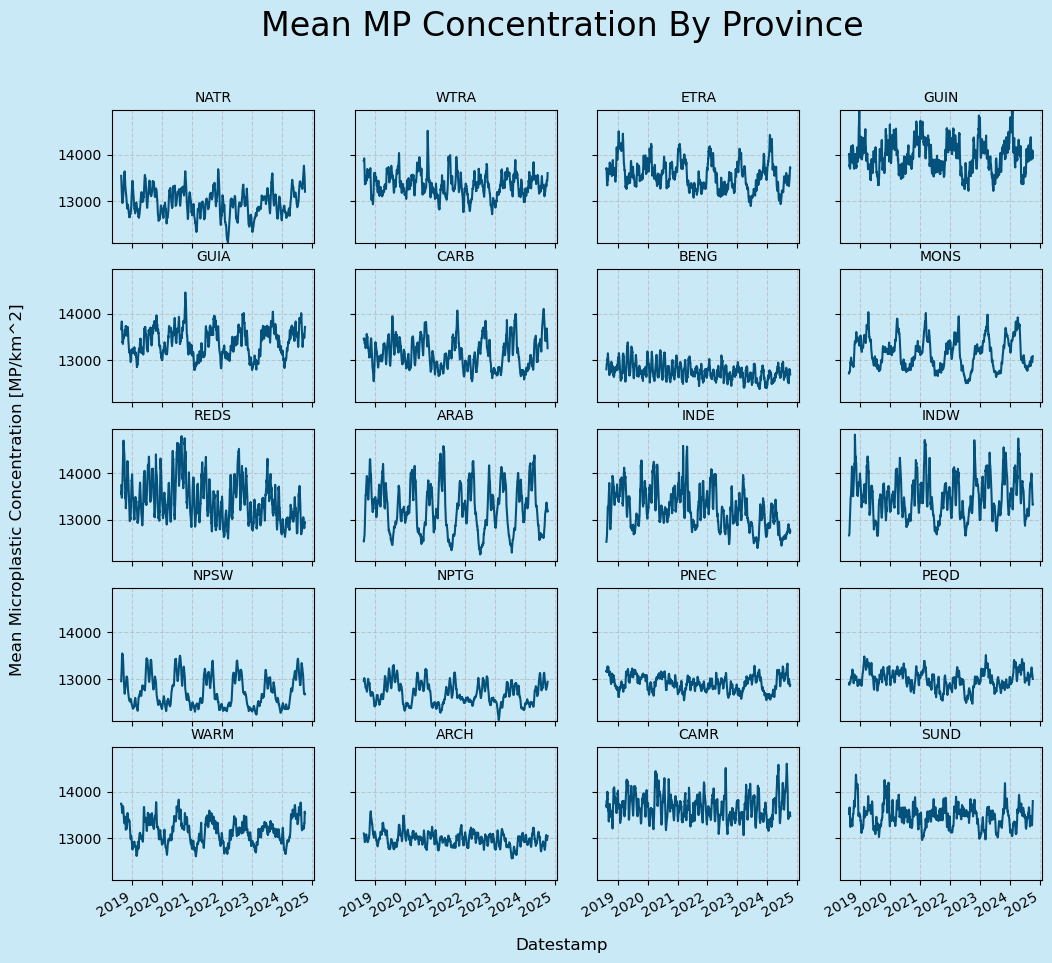

In [95]:
# Determine global y-axis limits across all 'mean' values in the data
y_min = filtered_df['mean'].apply(min).min()
y_max = filtered_df['mean'].apply(max).max()

# generate and format subplot figure
row, col = 5, 4
fig, axs = plt.subplots(row, col, figsize=(12, 10), sharex=True, sharey=True)  # Enable shared axes
fig.suptitle("Mean MP Concentration By Province", fontsize=24)
fig.patch.set_facecolor("#CAE9F7")

for i, (_, prov) in enumerate(filtered_df.iterrows()):
    ax = axs.flat[i]
    ax.plot(cygnss_data.time.values, prov['mean'], color='#04527C')
    ax.set_title(prov['ProvCode'], fontsize=10)
    ax.set_ylim(y_min, y_max)  # Set consistent y-axis limits
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor("#CAE9F7")

# Rotate x-axis labels for the bottom row of subplots
for ax in axs[-1, :]:  # Access the last row of axes
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha("right")


# Add shared x and y labels for the entire figure
fig.text(0.5, 0.04, "Datestamp", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Mean Microplastic Concentration [MP/km^2]", va="center", rotation="vertical", fontsize=12)

plt.show()


### Load Libraries for Modeling

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from prophet import Prophet
from datetime import datetime, timedelta


### Define data for MEDI as first pass

In [34]:
# define quick time series modeling
y = aggregated_df[aggregated_df['ProvCode'] == 'MEDI']['mean'].values[0]
X = cygnss_data.time.values

# reverse the order of the data for backcasting (might not be necessary)
y_rev = y[::-1]
X_rev = X[::-1]

18:17:49 - cmdstanpy - INFO - Chain [1] start processing
18:17:49 - cmdstanpy - INFO - Chain [1] done processing
/Users/ds/anaconda3/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/ds/anaconda3/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/ds/anaconda3/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a futu

Mean Absolute Error: 304.00
Root Mean Squared Error: 379.22

Trend and Seasonality Analysis:

Recent Trend:
                      ds         trend
3700 2028-10-02 12:00:00  13473.281117
3701 2028-10-03 12:00:00  13473.609485
3702 2028-10-04 12:00:00  13473.937854
3703 2028-10-05 12:00:00  13474.266223
3704 2028-10-06 12:00:00  13474.594592

Strongest Seasonal Periods:
Yearly seasonality range: -265.01 to 312.34


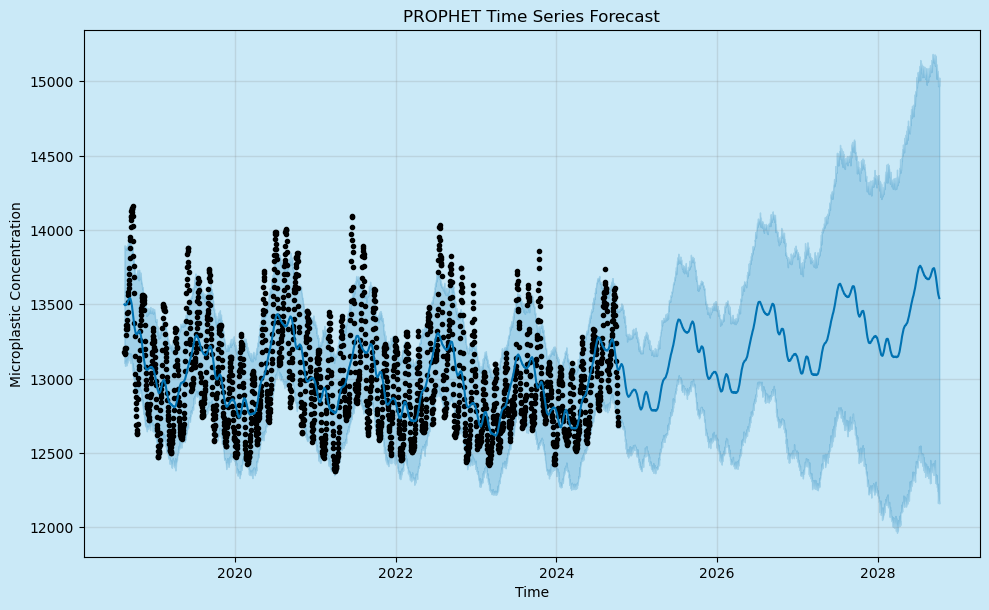

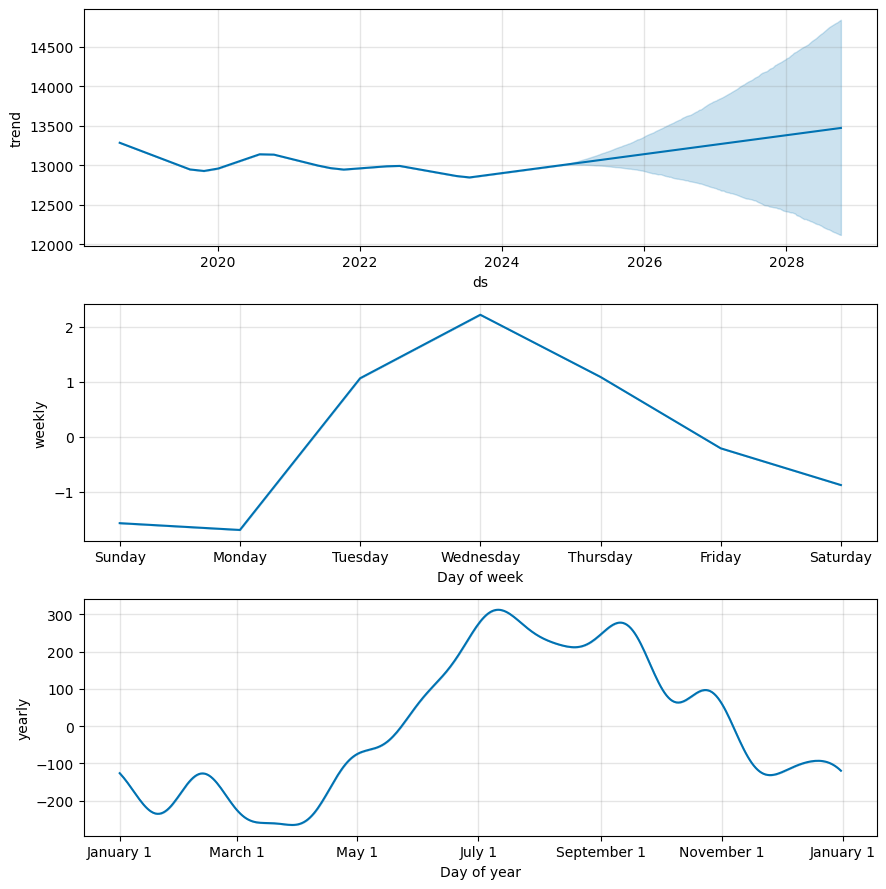

In [35]:
# Create DataFrame in Prophet format
prophet_df = pd.DataFrame({
                            'ds': X_rev,
                            'y':  y_rev
                         })

# Initialize and fit the Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,  # Flexibility of trend changes
    seasonality_prior_scale=10,    # Flexibility of seasonality
)
model.fit(prophet_df)

# Create future dates for prediction
future_dates = model.make_future_dataframe(periods=365*4)  # 90 days into the future

# Make predictions
forecast = model.predict(future_dates)

# Plot the results
fig = model.plot(forecast)
plt.title('PROPHET Time Series Forecast')
plt.ylabel('Microplastic Concentration')
plt.xlabel('Time')
fig = plt.gcf()
fig.patch.set_facecolor("#CAE9F7")
ax = plt.gca()
ax.set_facecolor("#CAE9F7")


# Plot components (trend, yearly seasonality, weekly seasonality)
fig_components = model.plot_components(forecast)


# Print some metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_true = prophet_df['y']
y_pred = forecast['yhat'][:len(y_true)]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# Get the trend and seasonal components
print("\nTrend and Seasonality Analysis:")
print("================================")
print("\nRecent Trend:")
recent_trend = forecast[['ds', 'trend']].tail()
print(recent_trend)

print("\nStrongest Seasonal Periods:")
yearly_seasonality = forecast[['ds', 'yearly']].agg(['min', 'max'])
print(f"Yearly seasonality range: {yearly_seasonality['yearly']['min']:.2f} to {yearly_seasonality['yearly']['max']:.2f}")

### Import libraries for Prophet CV

In [36]:
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

### Perform Quick CV Optimization

In [35]:
cutoffs = pd.to_datetime(['2021-01-01', '2022-01-01', '2023-01-01'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# print the best parameters based on lowest rmse
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()]
print(f'The best parameters are:\n\tchangepoint_prior_scale: {best_params.changepoint_prior_scale[0]} \
                                \n\tseasonality_prior_scale: {best_params.seasonality_prior_scale[0]}\n')

17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing
17:40:54 - cmdstanpy - INFO - Chain [1] start processing
17:40:54 - cmdstanpy - INFO - Chain [1] start processing
17:40:54 - cmdstanpy - INFO - Chain [1] start processing
17:40:54 - cmdstanpy - INFO - Chain [1] done processing
17:40:54 - cmdstanpy - INFO - Chain [1] done processing
17:40:54 - cmdstanpy - INFO - Chain [1] done processing
17:40:55 - cmdstanpy - INFO - Chain [1] start processing
17:40:55 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  371.671632
1                     0.001                     0.10  373.402601
2                     0.001                     1.00  373.405013
3                     0.001                    10.00  373.570295
4                     0.010                     0.01  425.758295
5                     0.010                     0.10  426.706701
6                     0.010                     1.00  426.803518
7                     0.010                    10.00  427.969690
8                     0.100                     0.01  379.146364
9                     0.100                     0.10  381.431190
10                    0.100                     1.00  380.384350
11                    0.100                    10.00  381.513580
12                    0.500                     0.01  856.713464
13                    0.500                     0.10  836.245478
14                    0.5

17:41:20 - cmdstanpy - INFO - Chain [1] done processing


### Generate Best Fit based on CV

In [36]:
best_model = Prophet(
                    yearly_seasonality=True,
                    weekly_seasonality=True,
                    daily_seasonality=False,
                    changepoint_prior_scale=0.001,  # Flexibility of trend changes
                    seasonality_prior_scale=0.01,    # Flexibility of seasonality
                    )
best_model.fit(prophet_df)

17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
latest_date = prophet_df['ds'].max()
one_year_ago = latest_date - pd.DateOffset(years=1)

# Create a dataframe for the backcast period
historical_dates = pd.date_range(
    start=one_year_ago,
    end=latest_date,
    freq='D'
)
historical_df = pd.DataFrame({'ds': historical_dates})

# Generate predictions
backcast = best_model.predict(historical_df)

# Get actual values for comparison
actual_data = prophet_df[prophet_df['ds'] >= one_year_ago].copy()

# Merge predictions with actual data
comparison = pd.merge(
    backcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    actual_data,
    on='ds',
    how='left'
)

In [38]:
comparison

,ds,yhat,yhat_lower,yhat_upper,y
0,2023-10-07 12:00:00,12997.845630,12595.328570,13334.526866,13388.849609
1,2023-10-08 12:00:00,12993.254875,12601.709668,13379.894336,13386.673828
2,2023-10-09 12:00:00,12992.095243,12626.514349,13394.868633,13395.349609
3,2023-10-10 12:00:00,12992.744990,12605.612078,13387.410254,13520.911133
4,2023-10-11 12:00:00,12991.767839,12597.716707,13355.264839,13594.675781
...,...,...,...,...,...
362,2024-10-03 12:00:00,12981.657781,12592.124170,13384.822422,12844.477539
363,2024-10-04 12:00:00,12973.283168,12594.943960,13344.239028,12785.725586
364,2024-10-05 12:00:00,12966.601850,12603.070299,13373.432756,12745.670898
365,2024-10-06 12:00:00,12960.621929,12549.254168,13341.039130,12710.018555


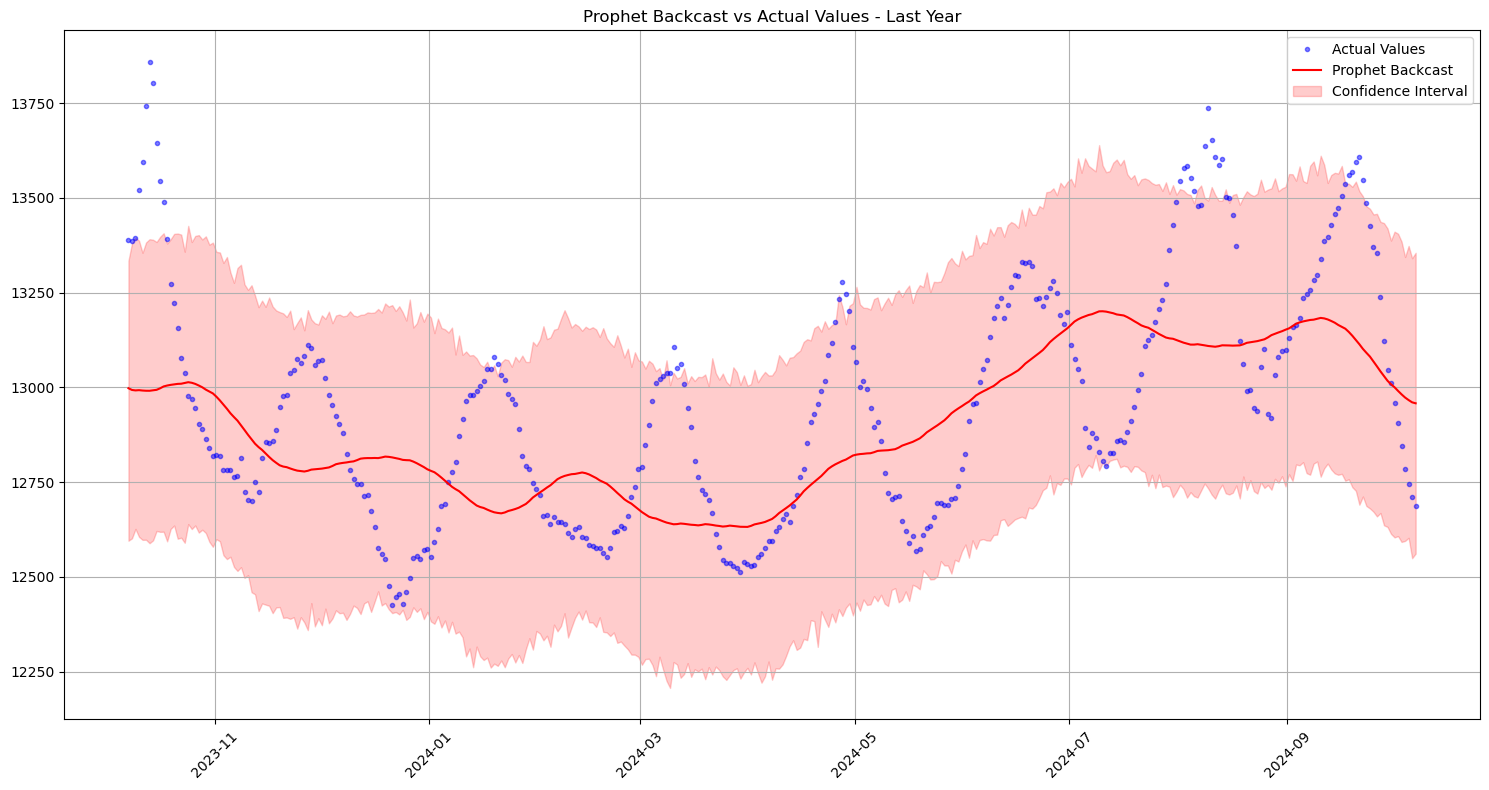

In [39]:
plt.figure(figsize=(15, 8))
    
# Plot actual values
plt.plot(comparison['ds'], comparison['y'], 'b.', 
        label='Actual Values', alpha=0.5)

# Plot predicted values
plt.plot(comparison['ds'], comparison['yhat'], 'r-', 
        label='Prophet Backcast')

# Plot confidence intervals
plt.fill_between(
    comparison['ds'],
    comparison['yhat_lower'],
    comparison['yhat_upper'],
    color='r',
    alpha=0.2,
    label='Confidence Interval'
)

plt.title('Prophet Backcast vs Actual Values - Last Year')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Testing Model Saving for Prophet

In [ ]:
from prophet.serialize import model_to_json, model_from_json

with open('20241102_serialized_prophet_model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

# with open('serialized_model.json', 'r') as fin:
#     m = model_from_json(fin.read())  # Load model

In [ ]:
with open('20241102_serialized_prophet_model.json', 'r') as fin:
    model = model_from_json(fin.read())  # Load model

In [ ]:
# Generate predictions
backcast = model.predict(historical_df)

# Get actual values for comparison
actual_data = prophet_df[prophet_df['ds'] >= one_year_ago].copy()

# Merge predictions with actual data
comparison = pd.merge(
    backcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    actual_data,
    on='ds',
    how='left'
)

plt.figure(figsize=(15, 8))
    
# Plot actual values
plt.plot(comparison['ds'], comparison['y'], 'b.', 
        label='Actual Values', alpha=0.5)

# Plot predicted values
plt.plot(comparison['ds'], comparison['yhat'], 'r-', 
        label='Prophet Backcast')

# Plot confidence intervals
plt.fill_between(
    comparison['ds'],
    comparison['yhat_lower'],
    comparison['yhat_upper'],
    color='r',
    alpha=0.2,
    label='Confidence Interval'
)

plt.title('Prophet Backcast vs Actual Values - Last Year')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()